In [1]:
from seagul.rl.ars.ars_pipe import ars
from seagul.nn import MLP
import torch
import matplotlib.pyplot as plt
from seagul.mesh import create_mesh, variation_dim, mesh_dim, create_box_mesh
import time
import copy
import gym
import torch

import xarray as xr
import numpy as np
import pandas as pd

import os

In [2]:
def identity(rews,obs,acts):
    return rews

def vardiv(rews, obs, acts):
    return rews/variation_dim(obs)

def varmul(rews, obs, acts):
    return rews*variation_dim(obs)

def rough_measure(x):
    d = torch.stack([x[t,:] - x[t-1,:] for t in range(1,x.shape[0])])
    return d.std()#$/(torch.abs(d.mean()))

def rmul(rews, obs, acts):
    return rews*rough_measure(obs)

def rdiv(rews, obs, acts):
    return rews/rough_measure(obs)

def pcastd(rews, obs, acts):
    pca = PCA()
    pca.fit((obs - obs.mean())/obs.std())
    return rews*pca.explained_variance_ratio_.std()


def mdim_mul(rews, obs, acts):
    m,_,_,_ = mesh_dim(obs)
    return m*rews

def mdim_div(rews, obs, acts):
    m,_,_,_ = mesh_dim(obs)
    return rews/m

def cdim_mul(rews, obs, acts):
    _,c,_,_ = mesh_dim(obs)
    return c*rews

def cdim_div(rews, obs, acts):
    _,c,_,_ = mesh_dim(obs)
    return rews/c


def madodiv(rews, obs, acts):
    return rews/variation_dim(obs, order=1)

def variodiv(rews, obs, acts):
    return rews/variation_dim(obs, order=2)

def radodiv(rews, obs, acts):
    return rews/variation_dim(obs, order=.5)



def do_rollout(env, policy, render=False):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while not done:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        if render:
            env.render()
            time.sleep(.05)

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length


def do_long_rollout(env, policy, ep_length):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while cur_step < ep_length:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length

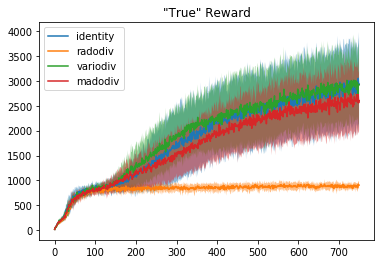

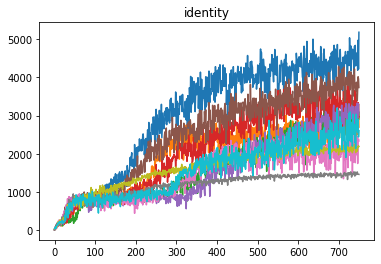

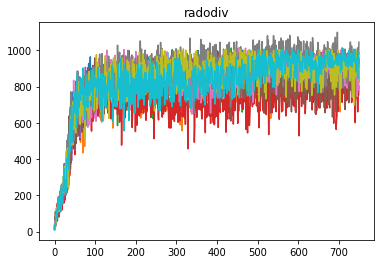

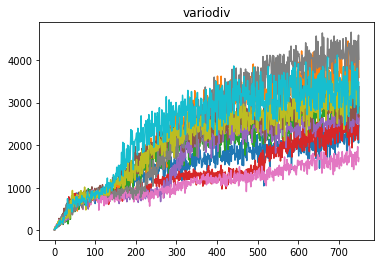

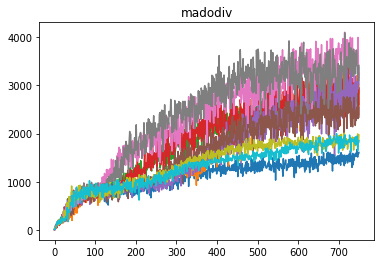

<Figure size 432x288 with 0 Axes>

In [6]:
data = torch.load("./data17/Walker2d-v2.xr")

policy_dict = data.policy_dict
rews = data.rews
exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
num_seeds = len(policy_dict['identity'])

#policy_dict = torch.load("./data/mjw_longermul.pol_dict")
#rews = torch.load("./data/mjw_longermul.data")

means = rews.mean(dim="trial")
stds = rews.std(dim="trial")

plt.plot(means.T)
plt.legend(exp_names)
ci = stds

for mean, c in zip(means, ci):
    plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
plt.title("\"True\" Reward")
plt.figure()

for exp_name in exp_names:  
    plt.plot(rews.loc[exp_name].T)
    plt.title(exp_name)
    plt.figure()

tensor([5463.7720])


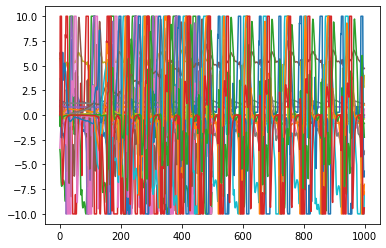

In [156]:
env_name = "Walker2d-v2"

policy = policy_dict['identity'][0]
env = gym.make(env_name)
#%time o,a,r,l = do_long_rollout(env, policy, ep_length= 1000)
o,a,r,l = do_rollout(env, policy, render=False)
print(sum(r))
start_idx = 500
plt.plot(o[start_idx:])
target = o[start_idx:]
plt.plot(o)

In [24]:
env_name = "Walker2d-v2"
r_thresh = 2000
num_runs = 5
num_seeds = len(policy_dict['identity'])
post_fns = [identity, madodiv, variodiv]
working_seeds = {fn.__name__: [] for fn in post_fns}

env = gym.make(env_name)
#%time o,a,r,l = do_long_rollout(env, policy, ep_length= 10000)
for post_fn in post_fns:
    for i in range(num_seeds):
        num_thresh=0; rtot=0
        
        for j in range(num_runs):
            policy = policy_dict[post_fn.__name__][i]
            o,a,r,l = do_rollout(env, policy)
            if sum(r) > r_thresh:        
                rtot += sum(r); num_thresh +=1
                if num_thresh == num_runs:
                    working_seeds[post_fn.__name__].append((i, rtot/num_runs))

In [52]:
top_seeds_dict = {}
top_seeds = {}
for key, value in working_seeds.items():
    top_seeds_dict[key] = sorted(value, reverse=True, key = lambda x: x[1])[:5]
    top_seeds[key] = [seed[0] for seed in top_seeds_dict[key]] 

In [189]:
import numpy as np
import copy
import scipy.optimize as opt
import torch
from collections.abc import MutableMapping


def mesh_dim(data, init_d=1e-2, mesh_fn=create_box_mesh):
    """
    Args:
        data - any np array or torch thing
        init_d - initial mesh size
    Returns:
        mesh_dim, mesh_sizes, d_vals

    """
    scale_factor = 1.5
    mesh_upper_bound = data.shape[0]/2

    mesh = mesh_fn(data, init_d)
    mesh_sizes = [len(mesh)]
    d_vals = [init_d]
    if not len(mesh)  > mesh_upper_bound:
        print("Warning initial d for mesh too large! auto adjusting")
        d = init_d/scale_factor
        while True:
            mesh = mesh_fn(data, d)
            mesh_sizes.insert(0, len(mesh))
            d_vals.insert(0, d)

            if mesh_sizes[0] > mesh_upper_bound:
                break
                
            d = d/scale_factor


    d = init_d*scale_factor
    while True:
        mesh = mesh_fn(data, d)
        mesh_sizes.append(len(mesh))
        d_vals.append(d)

        if mesh_sizes[-1] == 1:
            break

        d = d * scale_factor

    for i, m in enumerate(mesh_sizes):
        if m < mesh_upper_bound:
            lin_begin = i
            break

    xdata = np.log2(d_vals[lin_begin:])
    ydata = np.log2(mesh_sizes[lin_begin:])

    # Fit a curve to the log log line
    def f(x, m, b):
        return m * x + b

    popt, pcov = opt.curve_fit(f, xdata[:-1], -ydata[:-1])

    # find the largest slope
    min_slope = 0
    for i in range(len(ydata) - 2):
        slope = (ydata[i+1] - ydata[i]) / (xdata[i + 1] - xdata[i])
        if slope < min_slope:
            min_slope = slope

    return popt[0], -min_slope, mesh_sizes, d_vals


init_d = 1e-6
num_runs = 1; num_seeds=len(top_seeds['identity'])
post_fns = [identity, madodiv, variodiv]


msize1 = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

msize2 = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

msize4 = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

mshdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

cdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

vdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

mdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})


rdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})


for post_fn in post_fns:
    for i,seed in enumerate(top_seeds[post_fn.__name__]):
        for j in range(num_runs):
            policy = policy_dict[post_fn.__name__][seed]
            o,a,r,l = do_long_rollout(env, policy, ep_length=1000)
            target = o[200:]
            target = (target - target.mean(dim=0))/target.std(dim=0)
            #m,w = create_mesh(target,init_d)
            #assert(len(m) == len(target))
            
           
            m = create_box_mesh(target,.01)
            msize2.loc[post_fn.__name__,i,j] = len(m)
            
            m = create_box_mesh(target,.1)
            msize1.loc[post_fn.__name__,i,j] = len(m)
            
            m = create_box_mesh(target, 1)
            msize4.loc[post_fn.__name__,i,j] = len(m)
            

            mshdims.loc[post_fn.__name__,i,j], cdims.loc[post_fn.__name__,i,j] , _, _ = mesh_dim(target, init_d)
            mdims.loc[post_fn.__name__,i,j] = variation_dim(target)
            vdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=2)
            rdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=.5)



In [196]:
print("madogram dimension")
for fn in post_fns:
    mean = mdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = mdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

madogram dimension
identity mean: 1.0819229979946, std: 0.006817106022303334
madodiv mean: 1.063173010293871, std: 0.0196216944314167
variodiv mean: 1.0749918953773996, std: 0.010796879528894411


In [197]:
print("variogram dimension")
for fn in post_fns:
    mean = vdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = vdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")
   

variogram dimension
identity mean: 1.5409614989973002, std: 0.003408553011151654
madodiv mean: 1.5315865051469355, std: 0.009810847215708329
variodiv mean: 1.5374959476886996, std: 0.005398439764447233


In [198]:
print("radogram dimension")
for fn in post_fns:
    mean = rdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = rdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

radogram dimension
identity mean: 0.16384599598919952, std: 0.01363421204460676
madodiv mean: 0.1263460205877423, std: 0.03924338886283325
variodiv mean: 0.14998379075479912, std: 0.021593759057788754


In [199]:
print("mesh dimension")
for fn in post_fns:
    mean = mshdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = mshdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

mesh dimension
identity mean: 2.5101945372286543, std: 0.5122791601731862
madodiv mean: 2.6898060000789097, std: 0.3764504478041364
variodiv mean: 2.5645331948697767, std: 0.2618802613061667


In [200]:
print("cmesh dimension")
for fn in post_fns:
    mean = cdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = cdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

cmesh dimension
identity mean: 4.92110573490445, std: 0.6511688716039459
madodiv mean: 4.5148129119189715, std: 0.7954091457753617
variodiv mean: 5.043063130981642, std: 0.8252313577519085


In [201]:
print("vdim mean: \n", vdims.mean(dim='seed').to_series(), "\n")
print("vdim std: \n" , vdims.std(dim='seed').to_series(), "\n")

vdim mean: 
 post      run
identity  0      1.540961
madodiv   0      1.531587
variodiv  0      1.537496
dtype: float64 

vdim std: 
 post      run
identity  0      0.003409
madodiv   0      0.009811
variodiv  0      0.005398
dtype: float64 



In [69]:
print("mdim mean: \n", mdims.mean(dim='seed').to_series(), "\n")
print("mdim std: \n" , mdims.std(dim='seed').to_series(), "\n")

mdim mean: 
 post      run
identity  0      1.117767
varmul    0      0.746842
vardiv    0      1.279713
rmul      0      1.170129
rdiv      0      0.353929
dtype: float64 

mdim std: 
 post      run
identity  0      0.0
varmul    0      0.0
vardiv    0      0.0
rmul      0      0.0
rdiv      0      0.0
dtype: float64 



In [77]:
print("cdim mean: \n", cdims.mean(dim='seed').to_series(), "\n")
print("cdim std: \n" , cdims.std(dim='seed').to_series(), "\n")

cdim mean: 
 post      run
identity  0      4.954196
varmul    0      1.415037
vardiv    0      2.643856
rmul      0      2.125531
rdiv      0      3.087463
dtype: float64 

cdim std: 
 post      run
identity  0      0.0
varmul    0      0.0
vardiv    0      0.0
rmul      0      0.0
rdiv      0      0.0
dtype: float64 



In [ ]:
from seagul.mesh import create_mesh_dict

In [134]:
for post_name in ['identity' , 'vardiv' , 'rmul']: #seed = 10
    for seed in working_seeds[post_name]:
        for run in [0,1,2,3,4]:
            o,a,r,l = do_long_rollout(env,policy_dict[post_name][seed], ep_length=10000)

            #print("reward:", sum(r))
            #print("variation_dim: ", variation_dim(o))
            #print("roughness: ", rough_measure(o))
            #plt.plot(o)
            #plt.figure()
            #plt.plot(a)

            import scipy.io 
            import os

            o = np.array(o)
            a = np.array(a)
            r = np.array(r)
            os.makedirs(f"./k/env_{env_name}/post_{post_name}/seed_{seed}", exist_ok=True)
            scipy.io.savemat(f"./k/env_{env_name}/post_{post_name}/seed_{seed}/run_{run}.mat", mdict = {"obs":o, "act":a, "rew":r})

In [52]:

def power_var(X, l, ord):
    # Implements the power variation, used for the variation fractal dimension
    return 1 / (2 * len(X) - l) * np.sum(np.linalg.norm(X[l:] - X[:-l],ord=ord))

def power_var(X, l, ord):
    diffs = X[l:] - X[:-l]
    norms = np.zeros(diffs.shape[0])
    for i,d in enumerate(diffs):
        norms[i] = np.linalg.norm(d,ord=1)
        
    return 1 / (2 * len(X) - l) * np.sum(norms)



def variation_dim(X, order=1):
    # Implements the order p variation fractal dimension from https://arxiv.org/pdf/1101.1444.pdf (eq 18)
    # order 1 corresponds to the madogram, 2 to the variogram, 1/2 to the rodogram
    return 2 - 1/(order*np.log(2))*(np.log(power_var(X, 2, order)) - np.log(power_var(X, 1, order)))

